In [ ]:
!pip install pytorch-lightning
!pip install torchmetrics
!pip install rasterio
!pip install tim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 96.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error
import pytorch_lightning as L
import joblib
from tqdm import tqdm
import rasterio
import torchmetrics
import timm
import torch.nn as nn
import os
from google.colab import drive

In [ ]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Parámetros
logs_path = "/content/drive/MyDrive/teg_resnet18_arroz/04_resultados/resnet18_norm_z_seed_19"
scaler_path = "/content/drive/MyDrive/teg_resnet18_arroz/02_dataset/DATASETCONCAT64/scaler_z.pkl"

csv_file = "/content/drive/MyDrive/teg_resnet18_arroz/02_dataset/DATASETCONCAT64/sample_100_seed19.csv"
image_root_dir = "/content/drive/MyDrive/teg_resnet18_arroz/02_dataset/DATASETCONCAT64/images"

ckpt_path = "/content/drive/MyDrive/teg_resnet18_arroz/04_resultados/resnet18_norm_z_seed_19/lightning_logs/version_0/checkpoints/epoch=7-val_rmse=0.31-val_loss=0.05.ckpt"
epoca = "7_again"
BATCH_SIZE = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class SatelliteDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = f"{self.root_dir}/{row['filename']}"
        with rasterio.open(img_path) as src:
            img = src.read()  # (bands, H, W)
        if self.transform:
            img = self.transform(img)
        label = row['label']
        return torch.tensor(img, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

In [ ]:
# Crear dataset y dataloader
dataset = SatelliteDataset(csv_file, image_root_dir)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
class LightningRegressionTask(L.LightningModule):
    def __init__(self, model, model_name, learning_rate=0.001):
        super().__init__()
        self.save_hyperparameters(ignore=["model"])
        self.model = model
        #self.criterion = nn.MSELoss() # Cambiar perdida
        self.criterion = nn.HuberLoss()
        self.learning_rate = learning_rate
        self.name = model_name

        # Métricas de regresión
        self.mse = torchmetrics.MeanSquaredError()
        self.rmse = torchmetrics.MeanSquaredError(squared=False)
        self.mae = torchmetrics.MeanAbsoluteError()
        self.r2 = torchmetrics.R2Score()

        self.scaler = joblib.load(scaler_path)

        # Diccionarios de logs
        self.train_logs = {"epoch": [], "loss": [], "mse": [], "rmse": [], "mae": [], "r2": []}
        self.val_logs = {"epoch": [], "loss": [], "mse": [], "rmse": [], "mae": [], "r2": []}
        self.test_logs = {"epoch": [], "loss": [], "mse": [], "rmse": [], "mae": [], "r2": []}

        self.train_step_loss_logs = {"step_loss": []}
        self.val_step_loss_logs = {"step_loss": []}
        self.test_step_loss_logs = {"step_loss": []}

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        labels = labels.float().unsqueeze(1) # Asegúrate de que las dimensiones coincidan
        preds = self.model(images)
        loss = self.criterion(preds, labels)

        # Métricas de regresión
        mse = self.mse(preds, labels)
        rmse = self.rmse(preds, labels)
        mae = self.mae(preds, labels)
        r2 = self.r2(preds, labels)

        # Log de métricas
        self.log("train_step_loss", loss, on_step=True, on_epoch=False, prog_bar=True)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_mse", mse, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_rmse", rmse, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_mae", mae, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_r2", r2, on_step=False, on_epoch=True, prog_bar=True)
        self.train_step_loss_logs["step_loss"].append(loss.item())
        return loss

    def on_train_epoch_end(self):
        epoch = self.trainer.current_epoch
        self.train_logs["epoch"].append(epoch)
        self.train_logs["loss"].append(self.trainer.callback_metrics["train_loss"].item())
        self.train_logs["mse"].append(self.trainer.callback_metrics["train_mse"].item())
        self.train_logs["rmse"].append(self.trainer.callback_metrics["train_rmse"].item())
        self.train_logs["mae"].append(self.trainer.callback_metrics["train_mae"].item())
        self.train_logs["r2"].append(self.trainer.callback_metrics["train_r2"].item())

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        labels = labels.float().unsqueeze(1)
        preds = self.model(images)
        loss = self.criterion(preds, labels)

        # Métricas de regresión
        mse = self.mse(preds, labels)
        rmse = self.rmse(preds, labels)
        mae = self.mae(preds, labels)
        r2 = self.r2(preds, labels)

        self.log("val_step_loss", loss, on_step=True, on_epoch=False, prog_bar=True)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_mse", mse, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_rmse", rmse, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_mae", mae, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_r2", r2, on_step=False, on_epoch=True, prog_bar=True)
        self.val_step_loss_logs["step_loss"].append(loss.item())
        return loss

    def on_validation_epoch_end(self):
        epoch = self.trainer.current_epoch
        self.val_logs["epoch"].append(epoch)
        self.val_logs["loss"].append(self.trainer.callback_metrics["val_loss"].item())
        self.val_logs["mse"].append(self.trainer.callback_metrics["val_mse"].item())
        self.val_logs["rmse"].append(self.trainer.callback_metrics["val_rmse"].item())
        self.val_logs["mae"].append(self.trainer.callback_metrics["val_mae"].item())
        self.val_logs["r2"].append(self.trainer.callback_metrics["val_r2"].item())

    def on_fit_end(self):
        # Export logs
        train_logs_df = pd.DataFrame(self.train_logs)
        train_step_loss_logs_df = pd.DataFrame(self.train_step_loss_logs)
        train_logs_df.to_csv(f"logs-{self.name}_{normalization}_{seed}/training_logs_{self.name}.csv", index=False)
        train_step_loss_logs_df.to_csv(f"logs-{self.name}_{normalization}_{seed}/training_step_loss_logs_{self.name}.csv", index=False)

        val_logs_df = pd.DataFrame(self.val_logs)
        val_step_loss_logs_df = pd.DataFrame(self.val_step_loss_logs)
        val_logs_df.to_csv(f"logs-{self.name}_{normalization}_{seed}/validation_logs_{self.name}.csv", index=False)
        val_step_loss_logs_df.to_csv(f"logs-{self.name}_{normalization}_{seed}/validation_step_loss_logs_{self.name}.csv", index=False)

    def test_step(self, batch, batch_idx):
        images, labels = batch
        labels = labels.float().unsqueeze(1)
        preds = self.model(images)
        loss = self.criterion(preds, labels)

        mse = self.mse(preds, labels)
        rmse = self.rmse(preds, labels)
        mae = self.mae(preds, labels)
        r2 = self.r2(preds, labels)

        self.log("test_step_loss", loss, on_step=True, on_epoch=False, prog_bar=True)
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test_mse", mse, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test_rmse", rmse, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test_mae", mae, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test_r2", r2, on_step=False, on_epoch=True, prog_bar=True)
        self.test_step_loss_logs["step_loss"].append(loss.item())
        return loss

    def on_test_epoch_end(self):
        epoch = self.trainer.current_epoch
        self.test_logs["epoch"].append(epoch)
        self.test_logs["loss"].append(self.trainer.callback_metrics["test_loss"].item())
        self.test_logs["mse"].append(self.trainer.callback_metrics["test_mse"].item())
        self.test_logs["rmse"].append(self.trainer.callback_metrics["test_rmse"].item())
        self.test_logs["mae"].append(self.trainer.callback_metrics["test_mae"].item())
        self.test_logs["r2"].append(self.trainer.callback_metrics["test_r2"].item())

    def on_test_end(self):
        test_logs_df = pd.DataFrame(self.test_logs)
        test_step_loss_logs_df = pd.DataFrame(self.test_step_loss_logs)
        test_logs_df.to_csv(f"logs-{self.name}_{normalization}_{seed}/test_logs_{self.name}.csv", index=False)
        test_step_loss_logs_df.to_csv(f"logs-{self.name}_{normalization}_{seed}/test_step_loss_logs_{self.name}.csv", index=False)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def predict_step(self, batch, batch_idx):
      x = batch if len(batch) == 1 else batch[0]
      y_pred_norm = self(x)
      if self.scaler:
          y_pred_real = self.scaler.inverse_transform(y_pred_norm.detach().cpu().numpy())
          return y_pred_real
      return y_pred_norm

In [ ]:
# Cargar modelo Lightning con checkpoint .ckpt
resnet18_model = timm.create_model("resnet18", pretrained=False, in_chans=10, num_classes=1)
model = LightningRegressionTask.load_from_checkpoint(ckpt_path, model=resnet18_model, model_name="resnet18")
model.to(device)
model.eval()

LightningRegressionTask(
  (model): ResNet(
    (conv1): Conv2d(10, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)

In [ ]:
preds = []
trues = []
with torch.no_grad():
    for inputs, labels in tqdm(dataloader, desc="Inferencia"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs_norm = model(inputs)
        outputs = model.scaler.inverse_transform(outputs_norm.cpu().numpy())
        preds.extend(outputs.flatten())
        trues.extend(labels.cpu().numpy().flatten())

preds = np.array(preds)
trues = np.array(trues)

Inferencia: 100%|██████████| 2/2 [00:19<00:00,  9.99s/it]


In [ ]:
# Calcular métricas
n = preds.size
p = 10
r2 = r2_score(trues, preds)
mae = mean_absolute_error(trues, preds)
perc_error = np.mean(np.abs((trues - preds) / trues)) * 100
r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"R2 score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Porcentaje de Error: {perc_error:.2f}%")
print(f"R2 ajustado: {r2_adj:.4f}")

# Crear un diccionario con las métricas
metrics_dict = {
    'R2': [r2],
    'MAE': [mae],
    'Porcentaje_Error': [perc_error],
    'R2_Ajustado': [r2_adj]
}

# Convertir a DataFrame
metrics_df = pd.DataFrame(metrics_dict)

# Ruta del archivo CSV
csv_path = os.path.join(logs_path, "metricas_resultado_epoch_" + epoca + ".csv")

# Guardar DataFrame en CSV (sobrescribe si existe)
metrics_df.to_csv(csv_path, index=False)

print(f"Métricas guardadas en: {csv_path}")

R2 score: 0.8914
MAE: 21034.1543
Porcentaje de Error: 16.87%
R2 ajustado: 0.8792
Métricas guardadas en: /content/drive/MyDrive/teg_resnet18_arroz/04_resultados/resnet18_norm_mm_seed_37/metricas_resultado_epoch_last.csv


In [ ]:
 #Guardar resultados con predicciones y error
results_df = pd.read_csv(csv_file)
results_df['produccion_predicha'] = preds
results_df['error_porcentual'] = np.abs((results_df['label'] - preds) / results_df['label']) * 100
results_df.to_csv(logs_path + "/resultados_predicciones_epoch_" + epoca + ".csv", index=False)

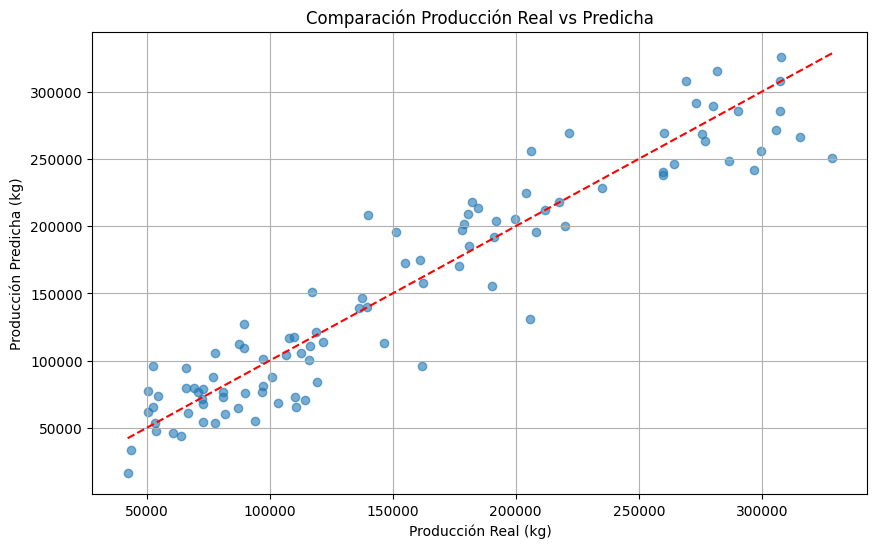

In [ ]:
# Graficar comparación real vs predicha
plt.figure(figsize=(10,6))
plt.scatter(trues, preds, alpha=0.6)
plt.plot([min(trues), max(trues)], [min(trues), max(trues)], 'r--')
plt.xlabel("Producción Real (kg)")
plt.ylabel("Producción Predicha (kg)")
plt.title("Comparación Producción Real vs Predicha")
plt.grid(True)
plt.savefig(logs_path + "/comparacion_real_vs_predicha_epoch_" + epoca + ".png")
plt.show()